In [1]:
# Implementation based on the following paper:

# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Neural Networks Basics:

In [ ]:
# At the first layer, the inputs are (batch x features),
# and features=number of input neurons of next layer,
# and the weight matrix for this layer is then (input_neurons x output_neurons) leading to:
# x @ W + b = y 
# (batch x input_neurons) @ (input_neurons x output_neurons) + (batch x output_neurons) = (batch x output_neurons)
# 
# Now at the next layer, the output of the first layer is now the input to the second layer, so:
# (batch x output_neurons) -> (batch x input_neurons), so:
# (batch x input_neurons) @ (input_neurons x output_neurons) + (batch x output_neurons) = (batch x output_neurons)
# and so on, until the final layer returns (batch x output_neurons=distribution over output space).

# But why does (x @ W + b) correctly reflect the forward pass operation?
# Each column of W contains all the weighted connections for 1 output neuron to all previous input neurons.
# So when the matrix multiplication operation performs the dot product between the first sample of x (i.e. x[0,:]),
# and the first column of W. (i.e. W[:,0]) it is effectively multiplying the signal from each input neuron by the
# weights assigned to them by the output neuron, which then returns the sum of its weighted connections, and then adds
# its bias b, and stored in the result y[0,0]. This is repeated for all output neurons.

# NOTE: the dimensions of the bias (b) are stored by Pytorch as (m,), and this just means 1 dimension, really.
# This is important because Pytorch can then broadcast the bias values along the batch dimension, which is the
# intended operation, as this effectively adds the bias of each output neuron to the result of each weighted sum performed
# by each output neuron from its inputs and weights. 

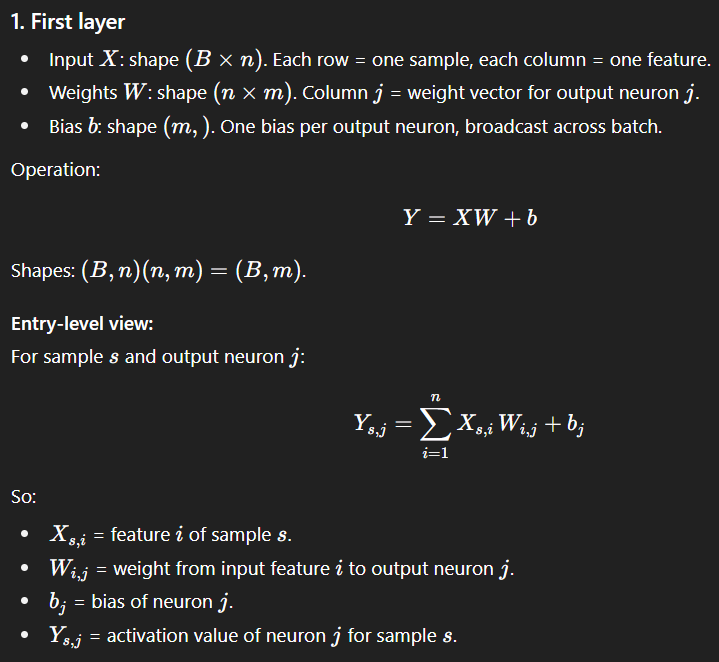

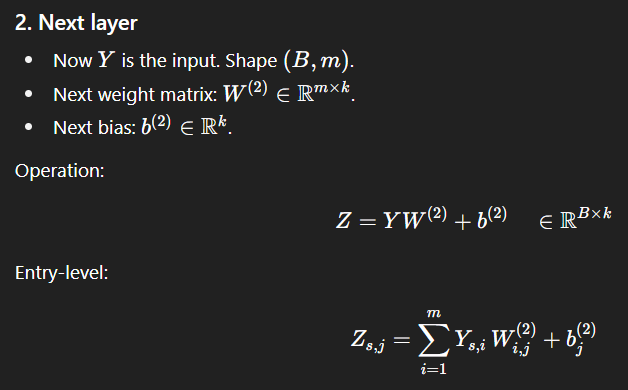

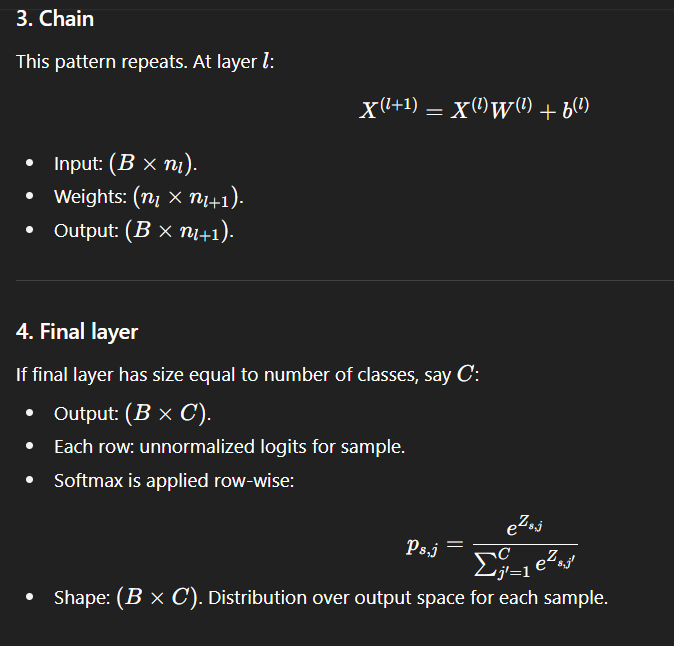

In [ ]:
# Key concept:
# Words are embedded in an n-dimensional embedding space.
# The MLP learns to organize this space in a way that forms understanding of semantics.
# The goal is to give similar embeddings to similar words.
# Each embedding dimensions will encode the model's compressed understanding.
# This allows the model to transfer knowledge and generalize to novel data.

In [3]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} # {} to create a dictionary, i+1 so the starting index is 1, enumerate returns an iterable of tuples
print(f'{stoi = }')

# Syntax is: {key_expression: value_expression for item in iterable}

stoi['.'] = 0 # Add start/end token with 0 index
itos = {i:s for s,i in stoi.items()}
print(f'{itos = }')

stoi = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
list(enumerate(chars))

[(0, 'a'),
 (1, 'b'),
 (2, 'c'),
 (3, 'd'),
 (4, 'e'),
 (5, 'f'),
 (6, 'g'),
 (7, 'h'),
 (8, 'i'),
 (9, 'j'),
 (10, 'k'),
 (11, 'l'),
 (12, 'm'),
 (13, 'n'),
 (14, 'o'),
 (15, 'p'),
 (16, 'q'),
 (17, 'r'),
 (18, 's'),
 (19, 't'),
 (20, 'u'),
 (21, 'v'),
 (22, 'w'),
 (23, 'x'),
 (24, 'y'),
 (25, 'z')]

In [8]:
# Build the dataset

block_size = 3 # Context length
X, Y = [], []

for w in words: # run with words[:5] if checking
    # print(w)
    context = [0] * block_size # Multiplication of a list with a positive integer replicates the contents of the list that many times. 
                               # here [0, 0, 0]
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), ' ----> ', itos[ix])
        
        context = context[1:] + [ix] # Crop and append. This essentially shifts the context window to the right.

X = torch.tensor(X)
Y = torch.tensor(Y) 

In [9]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [11]:
# Create the lookup table "C" of embeddings per character
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27,2), generator=g) # 27 characters embedded in a 2-dimensional space. Returns a tensor.
print(f'{C.shape = }, \n{C.dtype = }, \n{C = }')

C.shape = torch.Size([27, 2]), 
C.dtype = torch.float32, 
C = tensor([[ 1.5674, -0.2373],
        [-0.0274, -1.1008],
        [ 0.2859, -0.0296],
        [-1.5471,  0.6049],
        [ 0.0791,  0.9046],
        [-0.4713,  0.7868],
        [-0.3284, -0.4330],
        [ 1.3729,  2.9334],
        [ 1.5618, -1.6261],
        [ 0.6772, -0.8404],
        [ 0.9849, -0.1484],
        [-1.4795,  0.4483],
        [-0.0707,  2.4968],
        [ 2.4448, -0.6701],
        [-1.2199,  0.3031],
        [-1.0725,  0.7276],
        [ 0.0511,  1.3095],
        [-0.8022, -0.8504],
        [-1.8068,  1.2523],
        [ 0.1476, -1.0006],
        [-0.5030, -1.0660],
        [ 0.8480,  2.0275],
        [-0.1158, -1.2078],
        [-1.0406, -1.5367],
        [-0.5132,  0.2961],
        [-1.4904, -0.2838],
        [ 0.2569,  0.2130]])


In [12]:
C[X].shape # We can index into the tensor C using another tensor.

# The shape is (sample x character x embedding)
# Remember 1 "sample" is made of 3 characters (the preceding 3, to be exact) at that is why the first two dimensions are 32 x 3,
# and "embedding " consists of 2 values, which is why the last dimension is 2.

torch.Size([228146, 3, 2])

In [13]:
# Explanation of pytorch advanced indexing

# What Happens in C[X]?
# When you do C[X], you're not directly indexing C as if C were 3D. Instead, you're using the advanced indexing feature in PyTorch, 
# where the tensor X acts as a lookup table for rows in C. Here's how it works:

# Indexing Mechanism:
# X specifies which rows of C to select.
# Each ENTRY of X is an index that tells PyTorch which row of C to pick.

print(f'{C[0] = }') # This selects the first row of C
print(f'{C[X][0,:,0] = }') # This grabs the first embedding for each character in the first sample (sample = context, made of 3 characters)
                           # So the 3rd dimension is the useful one which contains the embeddings for each character


C[0] = tensor([ 1.5674, -0.2373])
C[X][0,:,0] = tensor([1.5674, 1.5674, 1.5674])


In [14]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [ ]:
# Build hidden layer

# Matrix of weights

W1 = torch.randn((6, 100), generator=g) # The NN takes the previous 3 characters and predicts the next one,
                                        # and each character was embedded using 2 values (2D embedding space).
                                        # This means that the NN takes (3 characters * 2 embeddings/character = 6 values),
                                        # and we set the layer to have 100 neurons.
                        
b1 = torch.randn(100, generator=g)      # Make 100 biases, 1 per neuron.

In [16]:
emb

tensor([[[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373]],

        [[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-0.4713,  0.7868]],

        [[ 1.5674, -0.2373],
         [-0.4713,  0.7868],
         [ 2.4448, -0.6701]],

        ...,

        [[ 0.2569,  0.2130],
         [ 0.2569,  0.2130],
         [-1.4904, -0.2838]],

        [[ 0.2569,  0.2130],
         [-1.4904, -0.2838],
         [ 0.2569,  0.2130]],

        [[-1.4904, -0.2838],
         [ 0.2569,  0.2130],
         [-0.5132,  0.2961]]])

In [17]:
emb.shape

torch.Size([228146, 3, 2])

In [18]:
# Now, the layer has to perform a matrix multiplication to operate on the inputs:

# Something like emb @ W1 + b1

# But this can't be done because the dimensions of emb and W1 are not compatible. Therefore, we need to reshape emb e.g. through concatenation.


torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)    # This grabs the embeddings of the 1st char, 2nd char, and 3rd char
                                                            # and adds them as columns (dim 1)

# The problem is that this code does not generalize because we have to manually list the tensors in the list that is passed to cat.

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        ...,
        [ 0.2569,  0.2130,  0.2569,  0.2130, -1.4904, -0.2838],
        [ 0.2569,  0.2130, -1.4904, -0.2838,  0.2569,  0.2130],
        [-1.4904, -0.2838,  0.2569,  0.2130, -0.5132,  0.2961]])

In [19]:
# Better way with torch.unbind(emb, 1), which is equal to [emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]] but generalizes.

torch.cat(torch.unbind(emb, 1), 1)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -0.4713,  0.7868],
        [ 1.5674, -0.2373, -0.4713,  0.7868,  2.4448, -0.6701],
        ...,
        [ 0.2569,  0.2130,  0.2569,  0.2130, -1.4904, -0.2838],
        [ 0.2569,  0.2130, -1.4904, -0.2838,  0.2569,  0.2130],
        [-1.4904, -0.2838,  0.2569,  0.2130, -0.5132,  0.2961]])

In [20]:
# But there is actually a more efficient way.

# Proof:

a = torch.arange(18)
print(f'{a = }, \n{a.shape = }, \n\n{a.storage() = }') # Note: a.storage() returns a TypedStorage object, which is deprecated. Use .untyped_storage()

# Note: In computer memory the data of a tensor is always represented as a 1D vector!
#       Pytorch then interprets this number sequence as a tensor of specific dimensions.

a = tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 
a.shape = torch.Size([18]), 

a.storage() =  0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]


C:\Users\emman\AppData\Local\Temp\ipykernel_7664\592617819.py:6: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print(f'{a = }, \n{a.shape = }, \n\n{a.storage() = }') # Note: a.storage() returns a TypedStorage object, which is deprecated. Use .untyped_storage()


In [21]:
# On the other hand,

print(f'{a.view(3,3,2) = }') # a.view(9, 9), a.view(6, 3), etc.

#  .view() is therefore more efficient than .cat() in PyTorch because .view() only alters the shape of the tensor by modifying its metadata, 
#  without changing the underlying data. This operation is computationally inexpensive since no new memory allocation occurs. 
#  In contrast, .cat() creates a new tensor by concatenating existing tensors, which involves copying data and allocating new memory, 
#  making it more resource-intensive.

# So instead we can do:

# print(f'\n{emb.view(32, 6) = }')


a.view(3,3,2) = tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [22]:
# Perform hidden layer operation

# emb.view(32, 6) @ W1 + b1
emb.view(emb.shape[0], 6) @ W1 + b1     # Even better so dims are not hardcoded.
                                        # emb.shape[0] selects the first dimension given by emb.shape.
                                        # Can also use -1 as the first dim so Pytorch derives it itself, knowing that the number of elements has to
                                        # be equal to the original tensor's.

# Corresponds to the logits of the hidden layer, pre-activation function

tensor([[-1.6952e+00,  8.5502e+00,  1.6284e+00,  ...,  2.2642e+00,
         -1.9505e-01,  1.8469e+00],
        [ 2.8741e-01,  4.3343e+00,  1.0142e+00,  ...,  2.8221e+00,
          3.9128e+00,  3.4733e+00],
        [-3.1026e+00,  9.9601e+00, -1.3306e+00,  ..., -5.7069e-01,
         -5.9107e+00, -6.9120e-03],
        ...,
        [-5.2934e-01,  3.2823e+00, -7.6118e-01,  ..., -2.0010e+00,
          4.2274e+00,  2.5265e+00],
        [-1.6717e+00,  2.8001e+00, -2.4148e+00,  ..., -1.4663e+00,
         -2.8894e+00,  6.8234e-01],
        [-2.1565e+00,  4.0522e-01, -1.3514e+00,  ..., -5.6185e-01,
          4.5460e+00, -3.3444e+00]])

In [ ]:
# Calculate activations

h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

print(f'{h = }, \n\n{h.shape = }')

h = tensor([[-0.9348,  1.0000,  0.9258,  ...,  0.9786, -0.1926,  0.9515],
        [ 0.2797,  0.9997,  0.7675,  ...,  0.9929,  0.9992,  0.9981],
        [-0.9960,  1.0000, -0.8694,  ..., -0.5159, -1.0000, -0.0069],
        ...,
        [-0.4849,  0.9972, -0.6418,  ..., -0.9641,  0.9996,  0.9873],
        [-0.9318,  0.9926, -0.9841,  ..., -0.8989, -0.9938,  0.5930],
        [-0.9736,  0.3844, -0.8744,  ..., -0.5093,  0.9998, -0.9975]]), 

h.shape = torch.Size([228146, 100])


In [ ]:
# Broadcasting correctness check:

print(f'{(emb.view(emb.shape[0], 6) @ W1).shape = }')
print(f'\n{b1.shape = }')

# So internally the broadcasting will

# 32, 100
#     100

# first align the dimensions from the right,

# 32, 100
#  1, 100

# then add a dimension made of 1s entries (this turns b1 into a row vector),
# and then this row vector will be copied vertically to match the (32 x 100) dim necessary for the addition

# Conclusion: broadcasting in this case achieves the desired operation as the element-wise addition is
# performed with the same values for every row, meaning each neuron (dim 1) adds the same bias to each sample.

(emb.view(emb.shape[0], 6) @ W1).shape = torch.Size([228146, 100])

b1.shape = torch.Size([100])


In [ ]:
# Make output layer

W2 = torch.randn((100, 27), generator=g) # 100 input values from the previous layer (1 per neuron), and 27 outputs (a probability distribution over 27 characters)
b2 = torch.randn(27, generator=g)

In [26]:
logits = h @ W2 + b2
print(f'{logits.shape = }')

logits.shape = torch.Size([228146, 27])


In [ ]:
# Implement softmax fxn

counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True) # Reminder: summing along dim 1 means summing 1 row across all it's columns (so it's a row sum)
                                            # Reminder: keepdim=True necessary otherwise 1 dimension is collapsed, messing with broadcasting

In [28]:
Y.shape # 1 label character per training sample

torch.Size([228146])

In [29]:
# Take the probabilities assigned by the NN to the correct characters (Y) following each sample sequence.

# prob[torch.arange(32), Y] # This provides two iterators of indices (tensors), since Pytorch supports advanced indexing there is no need to zip

In [ ]:
# Check number of total parameters

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)   

3481

In [ ]:
# Loss function - Negative log likelihood

# Manual NLL:

# loss = -prob[torch.arange(32), Y].log().mean()

loss = F.cross_entropy(logits, Y)   # Cross entropy loss is just NLL + built in softmax,
                                    # but more efficient since Pytorch uses a fused kernels to do all the operations and so uses less memory and time.
                                    # Additionally, backprop becomes more efficient because the derivatives of fused operations are analytically simpler.

print(f'{loss = }')

# Also, manual implementation runs into this problem:
 
# logits = torch.tensor([-100, -3, 0, 100]) # large positive number exceeds the range of the floating point datatype, resulting in "inf"
# counts = logits.exp()
# probs = counts / counts.sum()
# probs

# The way Pytorch solves this internally is that it scales the logits down by subtracting the highest logit, since this does not change the
# probabilities

loss = tensor(19.5052)


## Full implementation

In [32]:
print(f'{X.shape = }, \n{Y.shape = }') # Check data dims

X.shape = torch.Size([228146, 3]), 
Y.shape = torch.Size([228146])


In [33]:
# Parameters

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)  # number of parameters in total

3481

In [34]:
for p in parameters: # Pytorch requirement
    p.requires_grad = True

In [35]:
learning_rate_exp = torch.linspace(-3, 0, 1000) # 1000 elements
learning_rates = 10**learning_rate_exp

In [ ]:
lr_i = []
lre_i = []
loss_i = []

for i in range(1000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # Last parameter specifies the dimensions of the returned tensor, here (32,) means a 1D vector

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:    
        p.grad = None   # NOTE: Need to reset the gradients every training run.
                        # Otherwise the model would think the error is much larger than it actually is, 
                        # because it's adding errors from previous batches or iterations together, which is not relevant to the current iteration's
                        # loss!
    loss.backward()

    lr = learning_rates[i]
    # Update
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    lr_i.append(lr) # log learning rates
    lre_i.append(learning_rate_exp[i])
    loss_i.append(loss.item())

print(loss.item()) # final batch loss

5.962301254272461


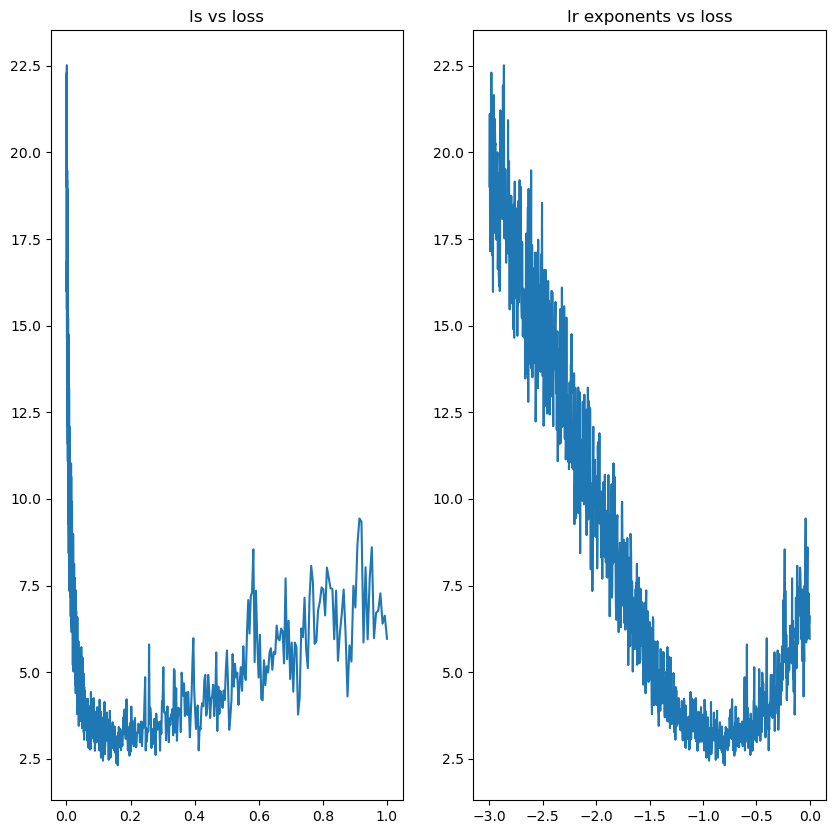

In [ ]:
# Plot learning rates vs losses
plt.figure(figsize=(16, 10))
# lr vs loss
plt.subplot(1, 2, 1)  
plt.plot(lr_i, loss_i)
plt.title('lr vs loss')

# lr exponents vs loss
plt.subplot(1, 2, 2)  
plt.plot(lre_i, loss_i)
plt.title('lr exponents vs loss')

plt.show()

# Conclusion: lr exponent around -1 (meaning lr around 0.1) is a fairly good lr for this case

In [38]:
# Final forward pass to check total loss:

emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y[ix])
loss

tensor(3.2085, grad_fn=<NllLossBackward0>)

## Repeat with determined lr

In [39]:
# Parameters

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 100, generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn(100, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)  # number of parameters in total

3481

In [40]:
for p in parameters: # Pytorch requirement
    p.requires_grad = True

In [41]:
lr = 0.1

for i in range(20000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # Last parameter specifies the dimensions of the returned tensor, here (32,) means a 1D vector

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:    
        p.grad = None   # IMPORTANT Note: Need to reset the gradients every training run.
                        # Otherwise the model would think the error is much larger than it actually is, 
                        # because it's adding errors from previous batches or iterations together, which is not relevant to the current iteration's
                        # loss!
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

# print(loss.item()) # final batch loss

In [42]:
# Final forward pass to check total loss:

emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y[ix])
loss

tensor(2.3092, grad_fn=<NllLossBackward0>)

In [43]:
# Use lower lr when close to convergence

lr = 0.01

for i in range(1000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # Last parameter specifies the dimensions of the returned tensor, here (32,) means a 1D vector

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:    
        p.grad = None   # IMPORTANT Note: Need to reset the gradients every training run.
                        # Otherwise the model would think the error is much larger than it actually is, 
                        # because it's adding errors from previous batches or iterations together, which is not relevant to the current iteration's
                        # loss!
    loss.backward()

    # Update
    for p in parameters:
        p.data += -lr * p.grad

# print(loss.item()) # final batch loss

In [44]:
# Final forward pass to check total loss:

emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y[ix])
loss

# Note: if loss on the whole data set goes up with more training iterations, it means the NN is overfitting to the batches it used

tensor(2.5346, grad_fn=<NllLossBackward0>)

## Using data set partitions

In [45]:
# Training split, dev/validation, test split
# 80%, 10%, 10%

In [46]:
def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size 

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), ' ----> ', itos[ix])
            
            context = context[1:] + [ix] # Crop and append. This essentially shifts the context window to the right.

    X = torch.tensor(X)
    Y = torch.tensor(Y) 
    
    print(f'{X.shape = }, {Y.shape = }')
    
    return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # partition indexes
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])
        

X.shape = torch.Size([182625, 3]), Y.shape = torch.Size([182625])
X.shape = torch.Size([22655, 3]), Y.shape = torch.Size([22655])
X.shape = torch.Size([22866, 3]), Y.shape = torch.Size([22866])


In [59]:
# Reset NN

# Parameters

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn(27, 2, generator=g)
W1 = torch.randn(6, 300, generator=g)   # Increased to 300 neurons from 100 (because train and test losses were not low enough but similar, 
                                        # indicating underfitting due to low model complexity)
b1 = torch.randn(300, generator=g)
W2 = torch.randn(300, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)  # number of parameters in total

10281

In [60]:
for p in parameters: # Pytorch requirement
    p.requires_grad = True

In [69]:
loss_i = []
lr = 0.1

step_i = []

for i in range(30000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # Last parameter specifies the dimensions of the returned tensor, here (32,) means a 1D vector

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:    
        p.grad = None   # IMPORTANT Note: Need to reset the gradients every training run.
                        # Otherwise the model would think the error is much larger than it actually is, 
                        # because it's adding errors from previous batches or iterations together, which is not relevant to the current iteration's
                        # loss!
    loss.backward()

    
    # Update
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    loss_i.append(loss.item())
    step_i.append(i)

# print(loss.item()) # final batch loss

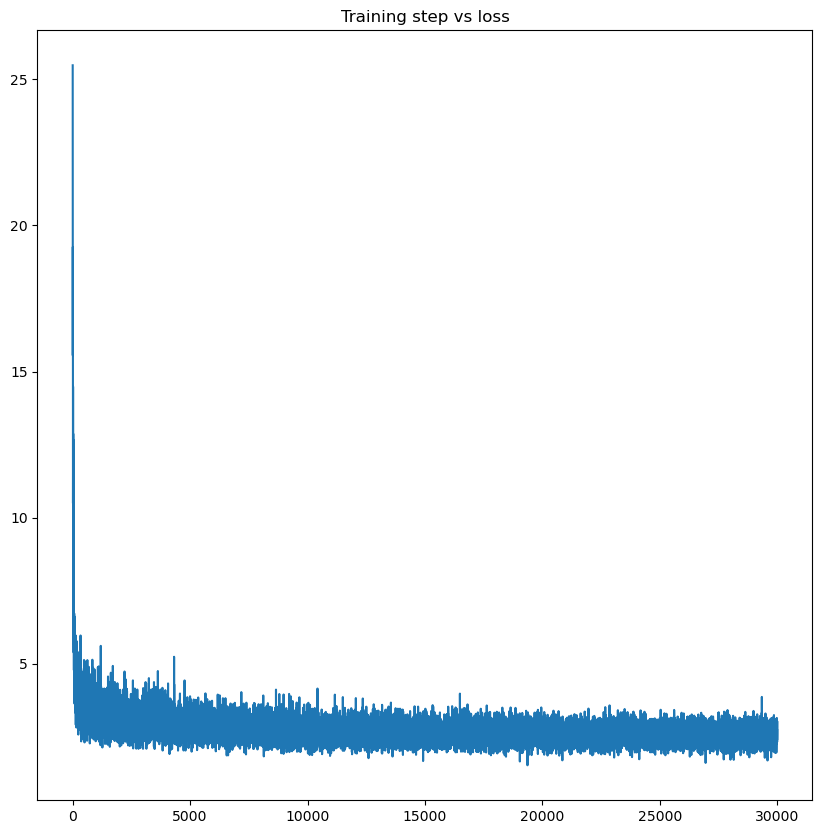

In [62]:
plt.figure(figsize=(10, 10))
plt.plot(step_i, loss_i)
plt.title('Training step vs loss')
plt.show()

# Note: the loss noise stems from the fact that we are using minibatches to train

In [70]:
# Check loss on dev set:

emb = C[X_dev] # (32, 3, 2), indexing into X_dev and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 300)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.2679, grad_fn=<NllLossBackward0>)

In [71]:
# Check loss on train set:

emb = C[X_train] # (32, 3, 2), indexing into X_train and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (32, 300)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.2762, grad_fn=<NllLossBackward0>)

In [53]:
# Considerations: 

# - The NN might be training on minibatches that are too small, making the convergence search too noisy
# - The embedding space might be too low in dimensions, meaning the NN is unable to use those dimensions to represent what it is trying to learn

In [54]:
# Observation:

# A lower learning rate can lead to faster loss reduction due to the increased stability it provides during training. 
# It allows for more controlled, accurate updates to the model parameters, helping the optimizer avoid overshooting, oscillations, 
# and other issues associated with higher learning rates. This results in a smoother and more consistent descent along the loss curve, 
# potentially leading to faster overall convergence even though each individual update is smaller.

## Visualize embedding vectors

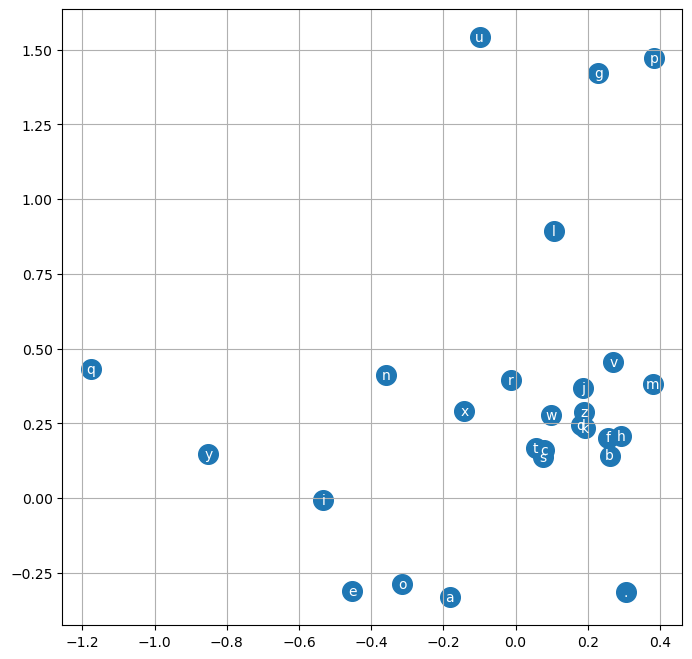

In [72]:
plt.figure(figsize=(8,8))

plt.scatter(C[:,0].data, C[:,1].data, s=200) # Remember C is the character embedding lookup table and it was updated during training!
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# Observations:

# - The network has learned to cluster the characters. For example, the vowels.


## 10D embedding space

In [76]:
# Reset NN

# Parameters

g = torch.Generator().manual_seed(2147483647)  
C = torch.randn(27, 10, generator=g)    # Increased from 2D to 10D embedding space
W1 = torch.randn(30, 200, generator=g)  # 3*10 inputs to hidden layer (3 chars * 10 embeddings/char)
b1 = torch.randn(200, generator=g)
W2 = torch.randn(200, 27, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

sum(p.nelement() for p in parameters)  # number of parameters in total

11897

In [77]:

for p in parameters: # Pytorch requirement
    p.requires_grad = True

In [78]:
loss_i = []
step_i = []

In [87]:
for i in range(100000):

    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (32,)) # Last parameter specifies the dimensions of the returned tensor, here (32,) means a 1D vector

    # Forward pass
    emb = C[X[ix]] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in parameters:    
        p.grad = None   # IMPORTANT Note: Need to reset the gradients every training run.
                        # Otherwise the model would think the error is much larger than it actually is, 
                        # because it's adding errors from previous batches or iterations together, which is not relevant to the current iteration's
                        # loss!
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01 # Use a larger learning rate for the first 50k iterations, then a smaller one
    # Update
    for p in parameters: # Note that the embeddings are also updated!
        p.data += -lr * p.grad

    # Track stats
    loss_i.append(loss.log10().item()) # 
    step_i.append(i)

# print(loss.item()) # final batch loss

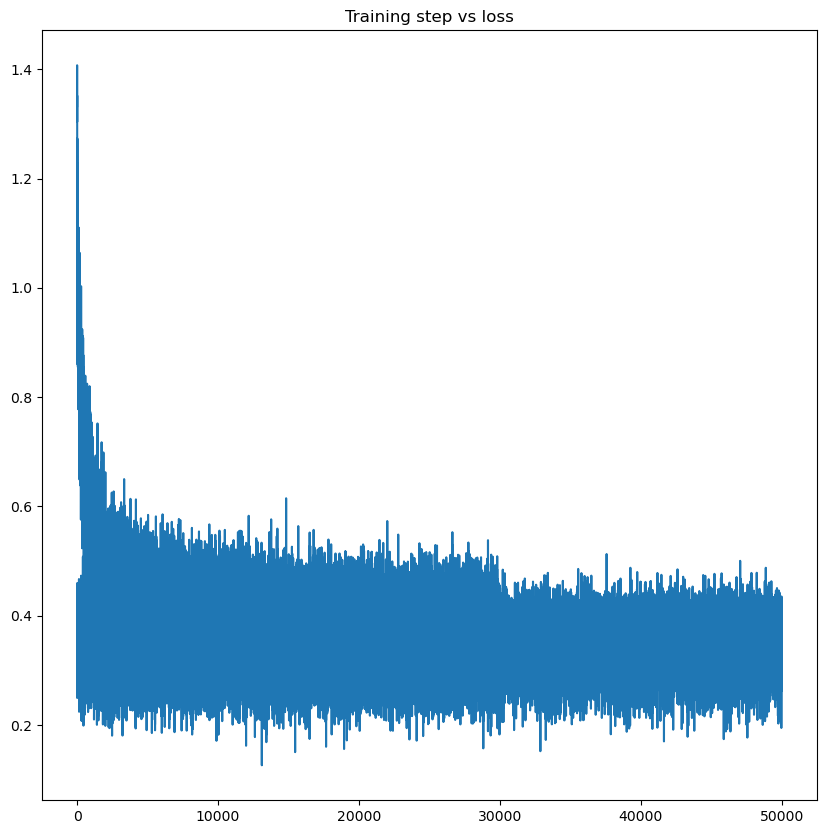

In [88]:
plt.figure(figsize=(10, 10))
plt.plot(step_i, loss_i)
plt.title('Training step vs loss')
plt.show()

In [89]:
# Check loss on dev set:

emb = C[X_dev] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
                                            # Hidden layer
logits = h @ W2 + b2    # (32, 27)
                        # Output layer
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1994, grad_fn=<NllLossBackward0>)

In [90]:
# Check loss on train set:

emb = C[X_train] # (32, 3, 2), indexing into X, which is the full training set, and grabbing 32 random samples
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 200)
                                            # Hidden layer.
logits = h @ W2 + b2    # (32, 27)
                        # Output layer.
loss = F.cross_entropy(logits, Y_train)
loss

# Note: The loss decreased when using a 10D embedding space over a 2D one.

tensor(2.2032, grad_fn=<NllLossBackward0>)

## Sample from the model

In [91]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d) because it's 1 example being generated, every forward pass adds a prediction until . is hit
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() # sample from predicted probability distribution over the characters
      context = context[1:] + [ix] # shift context
      out.append(ix) # append index of predicted character
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # convert indices to characters and print

    # Note: The model outputs are more name-like!

mona.
mayanniee.
mad.
rylla.
emmrstendrari.
aderedieliah.
milopaleigh.
sana.
araelynn.
hotra.
noshir.
rishiriel.
kinie.
jelipanthoor.
ube.
ged.
ryyah.
fiel.
yuge.
myskeyla.
